In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dòng mã **tf.random.set_seed(0)** được sử dụng để thiết lập hạt giống (seed) cho việc tạo số ngẫu nhiên trong thư viện TensorFlow. Bằng cách thiết lập hạt giống này thành 0, ta đảm bảo rằng các số ngẫu nhiên được tạo ra trong quá trình huấn luyện mô hình sẽ được tái tạo một cách nhất quán trong các lần chạy khác nhau. Điều này giúp cho việc tái sản xuất và so sánh kết quả huấn luyện mô hình trở nên dễ dàng hơn.

Dòng mã **pd.options.mode.chained_assignment = None** được sử dụng để tắt cảnh báo liên quan đến việc gán giá trị cho một DataFrame. Mặc định, pandas hiển thị cảnh báo khi thực hiện các toán tử gán trên một DataFrame để bảo vệ dữ liệu gốc khỏi bị thay đổi. Bằng cách đặt giá trị None cho pd.options.mode.chained_assignment, ta tắt cảnh báo này.

In [ ]:
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HPG1.csv')

In [ ]:

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
#df['Price'] = df.Price.str.replace(',','')
df.set_index('Date',inplace=True)
y = df['Price']
# y.values.reshape(-1, 1) được sử dụng để chuyển đổi mảng y thành một mảng 2D có kích thước
y = y.values.reshape(-1, 1)

In [ ]:
# df = df.reset_index()

Đoạn mã dưới thực hiện tỉ lệ hoá dữ liệu y để đảm bảo rằng dữ liệu nằm trong khoảng [0, 1]. Việc này giúp chuẩn hóa dữ liệu và cải thiện hiệu suất của mô hình khi sử dụng các thuật toán như mạng nơ-ron.

In [ ]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

Biến **n_lookback** (độ dài của các chuỗi đầu vào) phụ thuộc vào bài toán cụ thể và đặc điểm của dữ liệu.

Biến **n_forecast** được đặt thành 150, đại diện cho độ dài của các chuỗi đầu ra (kỳ dự báo). Điều này cho biết rằng chúng ta đang dự báo và mong đợi 150 điểm dữ liệu trong tương lai từ điểm dữ liệu hiện tại.

In [ ]:
# generate the input and output sequences (n_lookback=n_forecast/2)
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 120  # length of output sequences (forecast period)

Sau vòng lặp, ta sẽ có **mảng X** chứa các chuỗi đầu vào và **mảng Y** chứa các chuỗi đầu ra, sẵn sàng để được sử dụng cho huấn luyện mô hình.

In [ ]:
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

**Sequential**() là một lớp (class) trong thư viện Keras (một giao diện cao cấp của TensorFlow) được sử dụng để tạo một mô hình mạng nơ-ron tuần tự (sequential neural network).



**LSTM **(Long Short-Term Memory) là một kiểu lớp mạng nơ-ron trạng thái dài-ngắn, thường được sử dụng trong việc xử lý dữ liệu chuỗi (sequence data) như dữ liệu chuỗi thời gian. Nó giúp mô hình có khả năng "nhớ" thông tin quan trọng từ những quá khứ xa.

Dòng mã trên thêm một **lớp LSTM** vào mô hình tuần tự thông qua phương thức add() của đối tượng mô hình (model). Lớp LSTM này sẽ trả về chuỗi đầu ra và có đầu vào có hình dạng (n_lookback, 1).

In [ ]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

**Tạo dự báo**

X_ được khởi tạo bằng cách lấy chuỗi đầu vào cuối cùng (y[- n_lookback:]) từ dữ liệu và chuyển đổi nó thành mảng 3D với hình dạng (1, n_lookback, 1), đảm bảo rằng đầu vào có đúng hình dạng được yêu cầu bởi mô hình (số lượng mẫu, độ dài chuỗi đầu vào và số chiều).

Y_ được tạo bằng cách sử dụng phương thức predict() của đối tượng mô hình (model) để dự đoán chuỗi đầu ra tương ứng với X_. Kết quả dự đoán ban đầu có hình dạng (1, n_forecast, 1),sau đó được chuyển đổi lại thành mảng 2D với hình dạng (n_forecast, 1)

Cuối cùng, Y_ được chuyển đổi ngược trở lại đơn vị gốc bằng cách sử dụng scaler.inverse_transform().Điều này nhằm đảm bảo dự báo được trả về dưới dạng giá trị thực tế của dữ liệu ban đầu.

Tóm lại, lấy **dữ liệu X 60 ngày cuối** và tạo ra **dữ liệu dự báo Y 120** ngày sau đó.

In [ ]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 1s 866ms/step


In [ ]:
Y_.shape

(120, 1)

Tạo ra ra bảng **df_past** và ** df_future**.

**df_past** chứa 3 cột Date(index),Actual(Price),Forecast=null.Giá trị cuối cúa Forecast= giá trị cuối của Actual

** df_future** chứa 3 cột Date(df_past[index]+n_forecast),Actual =null,Forecast(Y_: giá dự đoán trong thời gian n_forecast).

In [ ]:
df_past = df[['Price']].reset_index()
df_past.rename(columns={'index': 'Date', 'Price': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

Tạo **bảng result** gồm 2 bảng df_past(Lấy Date và Actual) và df_furture(Lấy Date và Forecast), đổi tên các cột thành Date và Price, chạy lại chỉ số Date, đổi kiểu dữ liệ Price thành float để sử dụng

In [ ]:
past = df_past[['Date','Actual']]
past.rename(columns={'Actual':'Price'},inplace=True)
predict = df_future[['Date','Forecast']]
predict.rename(columns={'Forecast':'Price'},inplace=True)
results = past.append(predict).set_index('Date')
results = results.reset_index()
results['Price'] = results['Price'].astype('float')


<ipython-input-33-9f108af52561>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = past.append(predict).set_index('Date')


In [ ]:
results.info()

<Axes: xlabel='Date'>

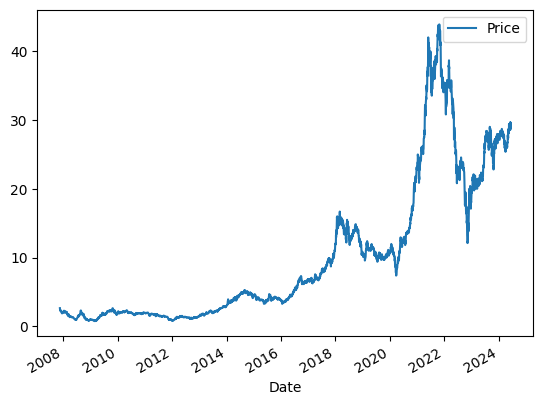

In [ ]:
results.plot(x = 'Date' , y = 'Price')

<Axes: xlabel='Date'>

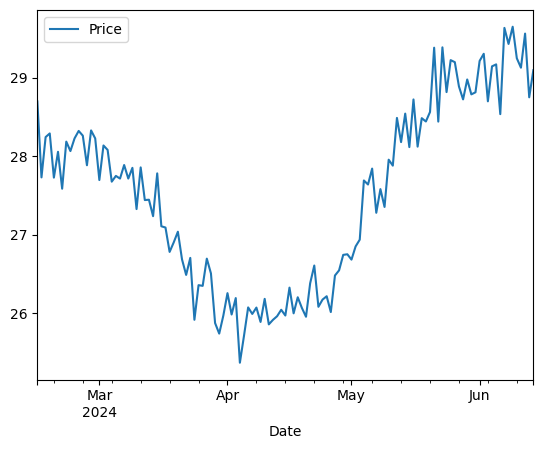

In [ ]:
results[(results['Date'] >= '2024-02-15') ].plot(x = 'Date' , y = 'Price')

In [ ]:
results[results['Date'] >= '2024-02-15']

In [ ]:
HPG_pre=results

Tạo hàm Predict_future_prices_stocks

In [ ]:
def Predict_future_prices_stocks (df: DataFrame):
  df['Date'] = pd.to_datetime(df['Date'])
  df.sort_values('Date',inplace=True)
  df.set_index('Date',inplace=True)
  y = df['Price']
  y = y.values.reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(y)
  y = scaler.transform(y)
  n_lookback = 60
  n_forecast = 120
  X = []
  Y = []

  for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
  X = np.array(X)
  Y = np.array(Y)
  # fit the model
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
  model.add(LSTM(units=50))
  model.add(Dense(n_forecast))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X, Y, epochs=100, batch_size=32, verbose=0)
  # generate the forecasts
  X_ = y[- n_lookback:]  # last available input sequence
  X_ = X_.reshape(1, n_lookback, 1)

  Y_ = model.predict(X_).reshape(-1, 1)
  Y_ = scaler.inverse_transform(Y_)

  df_past = df[['Price']].reset_index()
  df_past.rename(columns={'index': 'Date', 'Price': 'Actual'}, inplace=True)
  df_past['Date'] = pd.to_datetime(df_past['Date'])
  df_past['Forecast'] = np.nan
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
  df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
  df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
  df_future['Forecast'] = Y_.flatten()
  df_future['Actual'] = np.nan

  past = df_past[['Date','Actual']]
  past.rename(columns={'Actual':'Price'},inplace=True)
  predict = df_future[['Date','Forecast']]
  predict.rename(columns={'Forecast':'Price'},inplace=True)
  results = past.append(predict).set_index('Date')
  results = results.reset_index()
  results['Price'] = results['Price'].astype('float')

  return results



chỉ định chạy GPU

In [ ]:
tf.device("/GPU:0")

In [ ]:
HPG = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HPG1.csv')

In [ ]:
HPG_pre = Predict_future_prices_stocks(HPG)

In [ ]:
NKG = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NKG1.csv')

In [ ]:
NKG_pre = Predict_future_prices_stocks(NKG)

In [ ]:
VHM = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VHM1.csv')

In [ ]:
VHM_pre =Predict_future_prices_stocks(VHM)

In [ ]:
HPG_pre.to_csv('/content/drive/MyDrive/Colab Notebooks/HPG_pre.csv')

In [ ]:
NKG_pre.to_csv('/content/drive/MyDrive/Colab Notebooks/NKG_pre.csv')

In [ ]:
VHM_pre.to_csv('/content/drive/MyDrive/Colab Notebooks/VHM_pre.csv')

In [ ]:
NKG_pre

,Date,Price
0,2011-01-14,5.580000
1,2011-01-17,5.850000
2,2011-01-18,6.130000
3,2011-01-19,6.420000
4,2011-01-20,6.690000
...,...,...
3375,2024-06-10,30.510220
3376,2024-06-11,30.983326
3377,2024-06-12,31.069544
3378,2024-06-13,32.640820


In [ ]:
dfs = [HPG_pre, NKG_pre, VHM_pre]

In [ ]:
df_merged = pd.concat([df[['Date', 'Price']] for df in dfs], axis=1)

In [ ]:
df_merged

,Date,Price,Date,Price,Date,Price
0,2007-11-15,2.640000,2011-01-14,5.58,2018-05-17,64.36
1,2007-11-16,2.520000,2011-01-17,5.85,2018-05-18,64.36
2,2007-11-19,2.390000,2011-01-18,6.13,2018-05-21,64.36
3,2007-11-20,2.290000,2011-01-19,6.42,2018-05-22,68.85
4,2007-11-21,2.370000,2011-01-20,6.69,2018-05-23,64.25
...,...,...,...,...,...,...
4165,2024-06-10,27.908575,NaT,NaN,NaT,NaN
4166,2024-06-11,28.831743,NaT,NaN,NaT,NaN
4167,2024-06-12,29.601198,NaT,NaN,NaT,NaN
4168,2024-06-13,28.959389,NaT,NaN,NaT,NaN
